# <a id='toc1_'></a>[Feature Engineering](#toc0_)

In this notebook I'll explore alternate ways for dealing with structure of the data after wrangling. 

The Sepsis label in the data was added by the publishers of the data set and reflects a 6 hour window from ICU admission. 
This means that blood tests from patients that got Sepsis are labeled as control cases if the blood test is outside that 6 hour window.

The 6 hour window is an assumption about the predictive value of the bloodwork within that time frame. 
This assumption is built into the data set via the label column, but it's not necessarily optimal from an ML perspective. 

**Table of contents**<a id='toc0_'></a>    
- [Feature Engineering](#toc1_)    
- [Module and Data Imports](#toc2_)    
- [Additional EDA](#toc3_)    
  - [How many patients have a Sepsis diagnosis vs. A Sepsis label?](#toc3_1_)    
  - [How many CBC tests are there from people with a sepsis diagnosis?](#toc3_2_)    
  - [Do all rows with a Diagnosis of Sepsis have a value for SecToIcu?](#toc3_3_)    
  - [Do none of the rows with a Diagnosis of Control have a value for SecToIcu?](#toc3_4_)    
  - [How many of the cases with a Sepsis diagnosis fall into different time windows from ICU admission?](#toc3_5_)    
  - [Are there any patients with two tests labeled as Sepsis?](#toc3_6_)    
  - [Are there tests for the same patient that are labled Control or Sepsis based on the time frame?](#toc3_7_)    
- [Diagnosis feature vs. Label Feature](#toc4_)    
  - [Creation of Sepsis and Not_Sepsis class labels](#toc4_1_)    
- [Time and SecToIcu Features](#toc5_)    
  - [Option 1 - Eliminate the issue by excluding multiple tests from the same patient:](#toc5_1_)    
  - [Option 2 - Ignore the time component](#toc5_2_)    
  - [Option 3 - Use the exisiting time feature to capture some aspect of the time component](#toc5_3_)    
  - [Option 4 - Create a new set of features that captures the time component of the data.](#toc5_4_)    
- [Feature Engineering - Single Time Window](#toc6_)    
  - [Blood test sequence number](#toc6_1_)    
  - [Mean time between blood tests](#toc6_2_)    
    - [Calculate interval between tests](#toc6_2_1_)    
    - [Calculate Mean and Median Times between tests](#toc6_2_2_)    
  - [The mean, median, SD and EMA for CBC values](#toc6_3_)    
- [Feature Engineering - Multiple Time windows](#toc7_)    
  - [Calculate windows for both classes rows using the Time column](#toc7_1_)    
  - [Calculate windows for positive class using time to ICU admission](#toc7_2_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc2_'></a>[Module and Data Imports](#toc0_)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
sbc_data_cleaned = pd.read_csv('../data/processed/sbc_data_cleaned.csv', index_col=0)

In [3]:
sbc_data_cleaned.head()

,Id,Age,Sex,Diagnosis,Center,Set,Time,SecToIcu,CRP,HGB,MCV,PCT,PLT,RBC,WBC,Label,HrsToIcu
0,1,25,W,Control,Greifswald,Validation,0.0,NaN,15.5,7.0,80.5,NaN,264.0,4.2,8.40,Control,NaN
1,2,75,M,Control,Greifswald,Validation,0.0,NaN,7.4,8.4,87.9,NaN,260.0,4.8,8.47,Control,NaN
2,4,69,M,Control,Greifswald,Validation,0.0,NaN,NaN,7.8,91.7,NaN,179.0,4.2,9.15,Control,NaN
3,5,88,W,Control,Greifswald,Validation,0.0,NaN,NaN,8.2,88.2,NaN,234.0,4.3,7.59,Control,NaN
4,6,75,M,Control,Greifswald,Validation,0.0,NaN,NaN,8.1,96.7,NaN,197.0,4.2,7.85,Control,NaN


# <a id='toc3_'></a>[Additional EDA](#toc0_)

I'm doing more exploration of the data below. Trying to understand how it's put together and how the default labels fit within the larger struture of the data. 

## <a id='toc3_1_'></a>[How many patients have a Sepsis diagnosis vs. A Sepsis label?](#toc0_)

In [4]:
diagnosis_sepsis = sbc_data_cleaned[sbc_data_cleaned['Diagnosis']== 'Sepsis']


In [5]:
print(f'There are {len(diagnosis_sepsis["Id"].unique())} patients with a Sepsis diagnosis in the full data set.')

There are 3597 patients with a Sepsis diagnosis in the full data set.


## <a id='toc3_2_'></a>[How many CBC tests are there from people with a sepsis diagnosis?](#toc0_)

In [6]:
diagnosis_sepsis = sbc_data_cleaned[sbc_data_cleaned['Diagnosis']== 'Sepsis']

In [7]:
print(f'There are {len(diagnosis_sepsis)} CBC tests from patients with a Sepsis Diagnosis')
print(f'This an average of {len(diagnosis_sepsis)/len(diagnosis_sepsis["Id"].unique())} tests per patient.')

There are 20628 CBC tests from patients with a Sepsis Diagnosis
This an average of 5.7347789824854045 tests per patient.


I know from previous EDA that the average of 5.7 tests per patient isn't really correct. Most patients have 1 or a few tests and some have dozens and dozens.

## <a id='toc3_3_'></a>[Do all rows with a Diagnosis of Sepsis have a value for SecToIcu?](#toc0_)

In [8]:
diagnosis_sepsis['SecToIcu'].info()

<class 'pandas.core.series.Series'>
Index: 20628 entries, 381 to 1819434
Series name: SecToIcu
Non-Null Count  Dtype  
--------------  -----  
20628 non-null  float64
dtypes: float64(1)
memory usage: 322.3 KB


Yes, all rows with a Sepsis Diagnosis have a value for SecToIcu.

## <a id='toc3_4_'></a>[Do none of the rows with a Diagnosis of Control have a value for SecToIcu?](#toc0_)

In [9]:
diagnosis_control = sbc_data_cleaned[sbc_data_cleaned['Diagnosis']== 'Control']
diagnosis_control['SecToIcu'].info()

<class 'pandas.core.series.Series'>
Index: 1798807 entries, 0 to 1819427
Series name: SecToIcu
Non-Null Count  Dtype  
--------------  -----  
74670 non-null  float64
dtypes: float64(1)
memory usage: 27.4 MB


In [10]:
control_and_ICU = diagnosis_control[diagnosis_control['SecToIcu'].notnull()]
control_and_ICU['Label'].unique()

array(['Control'], dtype=object)

In [11]:
print(f'There are {len(control_and_ICU)} cases diagnosed as control that still went into the ICU.')

There are 74670 cases diagnosed as control that still went into the ICU.


So there are cases with a diagnosis of "control" that still entered the ICU. None of these cases is labeled as Sepsis and the 
original paper indicates that these would be cases that did not fall under the sepsis-related ICD-10 codes.

## <a id='toc3_5_'></a>[How many of the cases with a Sepsis diagnosis fall into different time windows from ICU admission?](#toc0_)

In [92]:
def time_window(num_hours,df):
    print(f"{len(df[df['HrsToIcu'] <= num_hours])} cases diagnosed with Sepsis have a cbc that falls within a {num_hours} hour window of ICU admission")

In [93]:
time_window(6,diagnosis_sepsis)
time_window(12,diagnosis_sepsis)

#One day
time_window(24,diagnosis_sepsis)
time_window(36,diagnosis_sepsis)

#2 days
time_window(48,diagnosis_sepsis)

#3 days
time_window(72,diagnosis_sepsis)

#4 days
time_window(96,diagnosis_sepsis)

#5 days
time_window(120,diagnosis_sepsis)

# 7 days
time_window(168,diagnosis_sepsis)

2464 cases diagnosed with Sepsis have a cbc that falls within a 6 hour window of ICU admission
3326 cases diagnosed with Sepsis have a cbc that falls within a 12 hour window of ICU admission
3962 cases diagnosed with Sepsis have a cbc that falls within a 24 hour window of ICU admission
4756 cases diagnosed with Sepsis have a cbc that falls within a 36 hour window of ICU admission
5203 cases diagnosed with Sepsis have a cbc that falls within a 48 hour window of ICU admission
6191 cases diagnosed with Sepsis have a cbc that falls within a 72 hour window of ICU admission
7095 cases diagnosed with Sepsis have a cbc that falls within a 96 hour window of ICU admission
7867 cases diagnosed with Sepsis have a cbc that falls within a 120 hour window of ICU admission
9201 cases diagnosed with Sepsis have a cbc that falls within a 168 hour window of ICU admission


## <a id='toc3_6_'></a>[Are there any patients with two tests labeled as Sepsis?](#toc0_)

In [14]:
centers = ['Leipzig', 'Greifswald']
patients_with_two_sepsis_labels = []


# Loop through each center because the IDs duplicate
for center in centers:
    print(center)
    center_df = sbc_data_cleaned[sbc_data_cleaned['Center']== center]
    center_ids =  center_df['Id'].unique().tolist()
    print(len(center_ids))

    #Loop through each unique value in ID
    for id in center_ids:
        id_df = center_df[center_df['Id']== id]

        if len(id_df) > 1:
            counts = id_df['Label'].value_counts()
            sep_count = counts.get('Sepsis', 0)  # Returns 0 if 'Sepsis' is not found
            
            if sep_count > 1: 
                patients_with_two_sepsis_labels.append(id)

print(f'There are {len(patients_with_two_sepsis_labels)} patients with more than one Sepsis Label')

Leipzig
708595
Greifswald
157922
There are 63 patients with more than one Sepsis Label


In [15]:
#pick a patient to look at in more detail
patients_with_two_sepsis_labels[0]

10128

In [16]:
id_10128 = sbc_data_cleaned[sbc_data_cleaned['Id'] ==10128]
id_10128.head(10)

,Id,Age,Sex,Diagnosis,Center,Set,Time,SecToIcu,CRP,HGB,MCV,PCT,PLT,RBC,WBC,Label,HrsToIcu
26190,10128,70,W,Control,Greifswald,Validation,0.0,NaN,NaN,8.2,89.6,NaN,260.0,4.20,5.35,Control,NaN
26191,10128,70,W,Control,Greifswald,Validation,69000.0,NaN,NaN,8.3,90.8,NaN,257.0,4.30,4.05,Control,NaN
455728,10128,41,M,Sepsis,Leipzig,Training,1320.0,19140.0,5.95,10.1,88.5,NaN,257.0,5.32,9.70,Sepsis,5.32
455729,10128,41,M,Sepsis,Leipzig,Training,2820.0,17640.0,5.90,10.2,90.1,NaN,271.0,5.46,10.00,Sepsis,4.90


So there are 63 patients with 2 blood tests labeled as Sepsis because they had two blood tests within the 6 hour window. 
If the window were to expand, there would be additional patients with more than one test in the Sepsis class. 
The sqeuence of the tests could be important in terms of prediction. More on that below. 

## <a id='toc3_7_'></a>[Are there tests for the same patient that are labled Control or Sepsis based on the time frame?](#toc0_)

In [17]:
diagnosis_sepsis['Label'].value_counts()

Label
Control    18164
Sepsis      2464
Name: count, dtype: int64

In [18]:
id_list = []
max_num_tests = 0
id_with_max_num_tests = 0

for patient in diagnosis_sepsis['Id'].unique():
    df = diagnosis_sepsis[diagnosis_sepsis['Id']==patient]
    counts = df['Label'].value_counts()

    if len(counts) == 2:
        id_list.append(patient)

        if len(df) > max_num_tests:
            max_num_tests = len(df)
            id_with_max_num_tests = patient



In [19]:
print(len(id_list), max_num_tests, id_with_max_num_tests)

756 416 195714


In [20]:
id_195714 = diagnosis_sepsis[diagnosis_sepsis['Id']== 195714]


In [21]:
id_195714['Label'].value_counts()

Label
Control    415
Sepsis       1
Name: count, dtype: int64

In [22]:
id_195714_sepsis_case = id_195714[id_195714['Label']=='Sepsis']

In [23]:
id_195714_time_sort = id_195714.sort_values(by = 'Time', ascending=True)

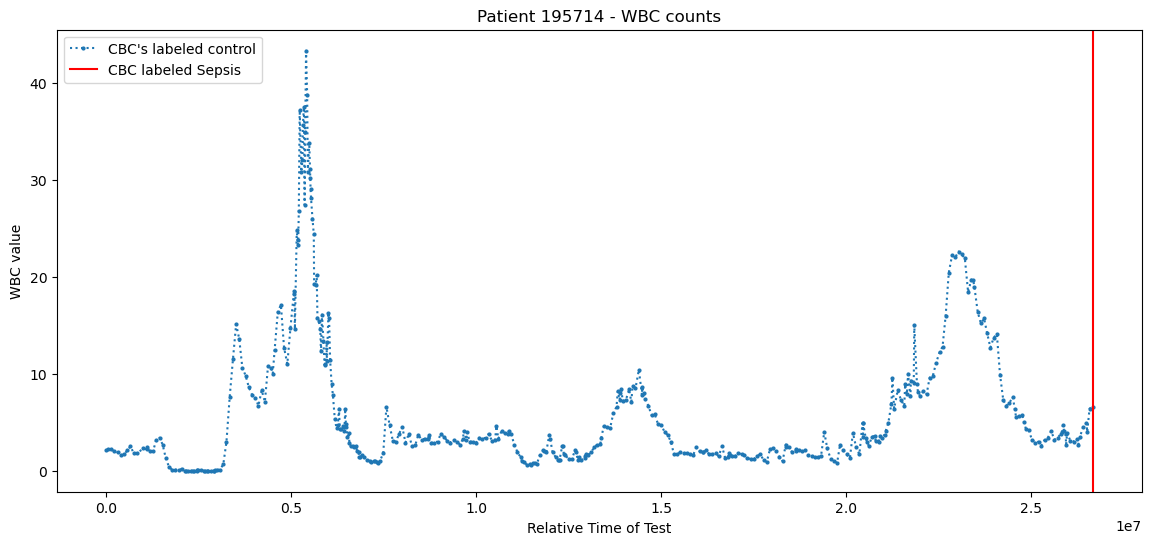

In [24]:
plt.figure(figsize=(14, 6))

time_feature = id_195714['Time']
sepsis_cbc = id_195714_sepsis_case['Time']

plt.plot(time_feature, id_195714['WBC'], linestyle=':', marker='o',markersize=2,label= 'CBC\'s labeled control')
plt.axvline(sepsis_cbc.iloc[0], color = 'r', label = 'CBC labeled Sepsis')

plt.title('Patient 195714 - WBC counts')
plt.xlabel('Relative Time of Test')
plt.ylabel('WBC value')

plt.legend()

plt.show()

The issue is shown here, for patients with multiple tests, and a Sepsis diagnosis, there are numerous tests labeled as control and then a small number of tests labeled as Sepsis. 
The question is when the blood tests become relevent for a Sepsis diagnosis.
The 6 hour window is what the publishers chose as the cut off point for the feature column. 
What does it look like if we out a few patients on the same plot? 

In [25]:
#Additional IDs with multiple tests - selected at random

id_4440 = diagnosis_sepsis[diagnosis_sepsis['Id']== 4440]
id_4440_sepsis_case = id_4440[id_4440['Label']=='Sepsis']
id_4440_time_sort = id_4440.sort_values(by = 'Time', ascending=True)

id_60877 = diagnosis_sepsis[diagnosis_sepsis['Id']== 60877]
id_60877_sepsis_case = id_60877[id_60877['Label']=='Sepsis']
id_60877_time_sort = id_60877.sort_values(by = 'Time', ascending=True)

id_535517 = diagnosis_sepsis[diagnosis_sepsis['Id']== 535517]
id_535517_sepsis_case = id_535517[id_535517['Label']=='Sepsis']
id_535517_time_sort = id_535517.sort_values(by = 'Time', ascending=True)

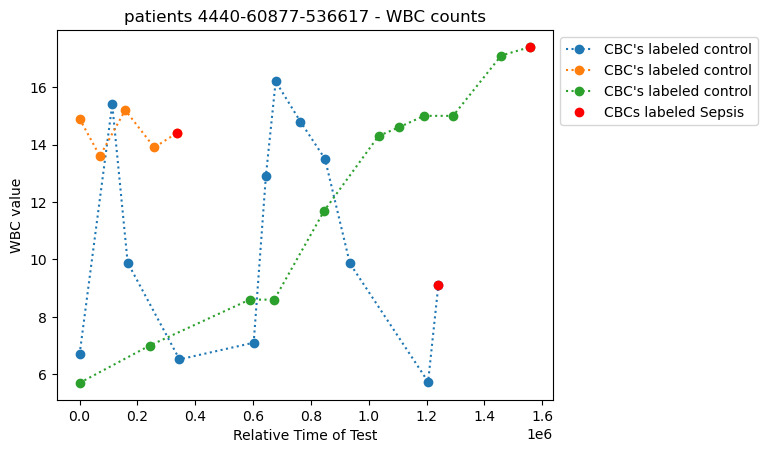

In [26]:

plt.plot(id_4440['Time'], id_4440['WBC'],linestyle=':', marker='o', label= 'CBC\'s labeled control')
plt.plot(id_60877['Time'], id_60877['WBC'],linestyle=':', marker='o', label= 'CBC\'s labeled control')
plt.plot(id_535517['Time'], id_535517['WBC'],linestyle=':', marker='o', label= 'CBC\'s labeled control')

# Highlight the last data point in red
plt.plot(id_4440['Time'].iloc[-1], id_4440['WBC'].iloc[-1], 'ro', label = 'CBCs labeled Sepsis')  
plt.plot(id_60877['Time'].iloc[-1], id_60877['WBC'].iloc[-1], 'ro')
plt.plot(id_535517['Time'].iloc[-1], id_535517['WBC'].iloc[-1], 'ro')
\
plt.title('patients 4440-60877-536617 - WBC counts')
plt.xlabel('Relative Time of Test')
plt.ylabel('WBC value')

plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.show()

All of these patients have a Sepsis diagnosis, and have blood tests labeled as control or Sepsis depending on how long before ICU admission the
test was done.

The X-axis here is the relative time of the test for each patient. So some patients have only a few tests close together before going into the ICU,
and some had several spread out before going into the ICU. The time starts from the patients first recorded test, which is labeled as time 0.

# <a id='toc4_'></a>[Diagnosis feature vs. Label Feature](#toc0_)

## <a id='toc4_1_'></a>[Creation of Sepsis and Not_Sepsis class labels](#toc0_)

The main issue here is the confusion situation where one patient with a Sepsis diagnosis has rows in the data labeled as either Sepsis or control depending on how much time passed from the test being done to ICU admisson for Sepsis. This results in things two blood tests from the same patient being labeled as Sepsis and control even if they are only minutes apart and the patient has a Sepsis diagnosis. In a case like this the test labeled as control would be treated the same as a test from someone who never got sepsis at all. 

To untangle this, I'll label all blood tests from patients who had a diagnosis of Sepsis as Sepsis, and all cases from blood tests where patients didn't have a Sepsis diagnosis as control. 

Time from ICU admission is still important in selecting which blood tests get labeled as Sepsis. I'll use that metric to select which of the rows labeled sepsis to include in the minority class.
There is already a feature for doing this easily, which I made earlier, called "HrsToIcu". "SecToIcu" would work as well, but the hours are easier to think about. 

This will split the data into two groups that don't overlap, the Non-Sepsis group, which consists of blood tests from people who never got Sepsis, and the Sepsis Group, which consists only of blood tests from people with a Sepsis diagnosis. 

In [27]:
sbc_data_cleaned.head()

,Id,Age,Sex,Diagnosis,Center,Set,Time,SecToIcu,CRP,HGB,MCV,PCT,PLT,RBC,WBC,Label,HrsToIcu
0,1,25,W,Control,Greifswald,Validation,0.0,NaN,15.5,7.0,80.5,NaN,264.0,4.2,8.40,Control,NaN
1,2,75,M,Control,Greifswald,Validation,0.0,NaN,7.4,8.4,87.9,NaN,260.0,4.8,8.47,Control,NaN
2,4,69,M,Control,Greifswald,Validation,0.0,NaN,NaN,7.8,91.7,NaN,179.0,4.2,9.15,Control,NaN
3,5,88,W,Control,Greifswald,Validation,0.0,NaN,NaN,8.2,88.2,NaN,234.0,4.3,7.59,Control,NaN
4,6,75,M,Control,Greifswald,Validation,0.0,NaN,NaN,8.1,96.7,NaN,197.0,4.2,7.85,Control,NaN


In [28]:
#drop the original label on the data adn the 'Set' column - That column is from the publishers of the original paper and isn't relevent here. It's preserved elsewhere.
sbc_data_cleaned_no_labels = sbc_data_cleaned.drop(labels = ['Label','Set'], axis = 1)

In [29]:
sbc_data_cleaned_no_labels.head()

,Id,Age,Sex,Diagnosis,Center,Time,SecToIcu,CRP,HGB,MCV,PCT,PLT,RBC,WBC,HrsToIcu
0,1,25,W,Control,Greifswald,0.0,NaN,15.5,7.0,80.5,NaN,264.0,4.2,8.40,NaN
1,2,75,M,Control,Greifswald,0.0,NaN,7.4,8.4,87.9,NaN,260.0,4.8,8.47,NaN
2,4,69,M,Control,Greifswald,0.0,NaN,NaN,7.8,91.7,NaN,179.0,4.2,9.15,NaN
3,5,88,W,Control,Greifswald,0.0,NaN,NaN,8.2,88.2,NaN,234.0,4.3,7.59,NaN
4,6,75,M,Control,Greifswald,0.0,NaN,NaN,8.1,96.7,NaN,197.0,4.2,7.85,NaN


In [30]:
#Add a new class column labeling each row based on a sepsis diagnosis or not - I could use the 'Diagnosis' column, but I find the control vs. Sepsis language confusing. 
#sbc_data_cleaned_no_labels['Class'] = sbc_data_cleaned_no_labels['Diagnosis'].where(sbc_data_cleaned_no_labels['Diagnosis'] == 'Sepsis', 'Not_Sepsis')
sbc_data_cleaned_no_labels['Class'] = sbc_data_cleaned_no_labels['Diagnosis'].apply(lambda x: 1 if x == 'Sepsis' else 0)

In [31]:
#rename the data frame for more clarity:
sbc_data_cleaned_with_classes = sbc_data_cleaned_no_labels
sbc_data_cleaned_with_classes.head()

,Id,Age,Sex,Diagnosis,Center,Time,SecToIcu,CRP,HGB,MCV,PCT,PLT,RBC,WBC,HrsToIcu,Class
0,1,25,W,Control,Greifswald,0.0,NaN,15.5,7.0,80.5,NaN,264.0,4.2,8.40,NaN,0
1,2,75,M,Control,Greifswald,0.0,NaN,7.4,8.4,87.9,NaN,260.0,4.8,8.47,NaN,0
2,4,69,M,Control,Greifswald,0.0,NaN,NaN,7.8,91.7,NaN,179.0,4.2,9.15,NaN,0
3,5,88,W,Control,Greifswald,0.0,NaN,NaN,8.2,88.2,NaN,234.0,4.3,7.59,NaN,0
4,6,75,M,Control,Greifswald,0.0,NaN,NaN,8.1,96.7,NaN,197.0,4.2,7.85,NaN,0


So now there are two groups in the data. A Sepsis class (1) and a not Sepsis class (0). 

The Sepsis class consists of all the blood tests from any patient that had a sepsis diagnosis. 

The Not Sepsis class consists of all the blood tests from any patient that did not have a sepsis diagnosis.

# <a id='toc5_'></a>[Time and SecToIcu Features](#toc0_)

At this point, not all of these blood tests are equal in terms of their columns.  For Sepsis patients that have more than one blood test in the data, there are two time features as follows:

- Time
This feature is the relative time of the blood test. The first test is coded as 0, and the following test have a time value cooresponding to the number of seconds
from the first 0.0 test. These numbers count up from the first test.

- SecToIcu / HrsToIcu
This is the amount of time from the blood test to ICU admission. These numbers count down towards ICU admission. So for a given patient, the lowest time value will be the
highest SecToIcu value and vice versa. 

I'll be using the SecToIcu values for the Sepsis cases to determine which Sepsis blood tests cases to include in the Sepsis class for modeling purposes. This 
was the approach of the publishers of the data in their study. They used only a 6 hour window, I'll be trying a range of time windows, but in both cases the windows are determined by the 
SecToIcu variable. 

The Non-sepsis class has the time feature in common with the Sepsis class, but it has NaN values for SecToIcu and HrsToIcu. So it's not a 1 to one comparison, becasue 
most of the Non-Sepsis class didn't go into the ICU at all.

It's important to deal with this time issue because it's clear that some patients in the Sepsis class will have multiple blood tests that fall within a given time window.
It would be great to preserve the sequential nature of those tests if possible in the model. 

It's also very important not to show the model any data indicating which rows have a value for SecToIcu. Rows where that value is not Nan will tend strongly to be Sepsis class,
and there would be data leakage in the model. 

There are several approaches that might be taken here to address this issue. 


## <a id='toc5_1_'></a>[Option 1 - Eliminate the issue by excluding multiple tests from the same patient:](#toc0_)
I could just exclude repeat tests from the same person if they are included in a given time window. There is already a large class imbalance issue here, so excluding data like this
seems less than optimal. It also assumes that the multiple tests are not important, which may or may not be true. No way to know at this point. 

## <a id='toc5_2_'></a>[Option 2 - Ignore the time component](#toc0_)
This would mean treating each as a stand alone data point and ignoring that some of them come from the same people and have sequential order. 
All the tests would be kept in this case, preserving as much Sepsis class data as possible. This is basically what the prior team did in their model. 
They used the Age, Sex, and CBC features in their model. They didn't use the time feature and they didn't do any feature engineering that I could find to capture
the sequential nature of tests from patients that had more than 1. 

## <a id='toc5_3_'></a>[Option 3 - Use the exisiting time feature to capture some aspect of the time component](#toc0_)

All of the rows for both classes have a time feature. It counts forward from the first blood test to the last. 
Higher values mean the blood test happened a longer time from the first test for that patient. 

However, any time value can only be interpreted in the context of a particular patient. 
Given a particular patient x, and a particular time value for test y, you know how much time passed between the first test for patient x and and test y. 
If there are multiple tests for patient x they can all be put in sequence. But, if you have time values from tests for two different patients there is no relationship between the values. 
The value doesn't tell you anything. 

Additionally, and especially for the Sepsis class, we're interested in the blood tests at the end of the sequence, that is the ones with the highest numbers.
For a blood tests in the Sepsis class you can say that a test with a higher number is taken closer to ICU admission, but you still don't know how close it is. 
For the Not_Sepsis class, a higher number just tells you that the test is further along in the sequnece of tests. There could be 2 tests before that test, or 50, there is no way to know with the current data. 

Given the above, it seems like the time feature alone is not adequate as a feature to capture the time component of the tests. It would have some utility for Sepsis class blood tests, 
but for Not_Sepsis class it's just an arbitrary number in some sense. 

## <a id='toc5_4_'></a>[Option 4 - Create a new set of features that captures the time component of the data.](#toc0_)

The issue with the time feature is that it counts up from the first test and isn't comparable between the classes. A feature like the Sepsis class "SecToIcu"
would be perfect, but the Not_Sepsis class doesn't have a value for this feature. It's mostly NaN values. There is also the important fact that when the model
is used, any ICU admission (or lack thereof) is in the future. So creating features that are based on counting backwards from that point doesn't make sense. 

There is actually a lot of information in the time feature that can be broken out into new features for each blood test. For each blood test, additional features like the below would better capture the context for that blood test if it's in a sequence for a single patient. 

- Number of tests taken so far
- Mean time between tests that have happened so far in the sequence
- Median time between tests that have happened so far in the sequence

For each CBC blood test values:
- The mean of all values at that point in the sequence. 
- The median of all values value at that point in the sequence. 
- The standard deviation of all values value at that point in the sequence. 


If there is only a single blood test for a patient - which is the case for a lot of the data, the same information would be captured, but the features would just reflect the one test. 
The mean value would be the same as the single value for a given blood test etc. 

This would apply for the whole data set as a single time window. But it also seems like a good idea to look at various time windows in the data, specifically time windows that allow us to use data from the Sepsis cases that is closer to ICU admission. It makes intuitive sense that a blood test 3 hours before ICU admission with Sepsis will contain more information about Sepsis than a blood test from 6 months before ICU admission. By using a series of time windows, I can test that assumption. A sliding time window may require different features to capture the time component. This is dealt with in a separate section below.

# <a id='toc6_'></a>[Feature Engineering - Single Time Window](#toc0_)

Each center will need to be dealt with independently because the Id numbers for each center repeat. I'll create the needed features 
for each center independently and then concatenate them back into a single data frame. 

In [32]:
#Split the centers
leipzig_data = sbc_data_cleaned_with_classes[sbc_data_cleaned_with_classes['Center']=='Leipzig']
greifswald_data = sbc_data_cleaned_with_classes[sbc_data_cleaned_with_classes['Center']=='Greifswald']

## <a id='toc6_1_'></a>[Blood test sequence number](#toc0_)

In [33]:
# Sort by ID and Time
leipzig_data = leipzig_data.sort_values(by=['Id','Time'])
greifswald_data = greifswald_data.sort_values(by=['Id','Time'])
leipzig_data.head(20)

,Id,Age,Sex,Diagnosis,Center,Time,SecToIcu,CRP,HGB,MCV,PCT,PLT,RBC,WBC,HrsToIcu,Class
438077,1,79,M,Control,Leipzig,420.0,NaN,0.75,8.1,86.0,NaN,167.0,4.36,7.3,NaN,0
438078,2,35,M,Control,Leipzig,0.0,NaN,NaN,10.6,79.9,NaN,199.0,6.02,4.7,NaN,0
438079,3,47,W,Control,Leipzig,0.0,NaN,3.87,8.7,89.9,NaN,298.0,4.37,7.1,NaN,0
438080,4,28,M,Control,Leipzig,780.0,NaN,0.52,9.9,96.2,NaN,216.0,4.79,5.3,NaN,0
438081,5,63,W,Control,Leipzig,0.0,NaN,232.87,7.4,86.6,NaN,189.0,3.96,20.9,NaN,0
438082,5,63,W,Control,Leipzig,540060.0,NaN,13.32,6.5,90.2,NaN,349.0,3.56,7.1,NaN,0
438083,6,36,W,Control,Leipzig,0.0,NaN,0.62,7.1,85.8,NaN,315.0,3.81,9.7,NaN,0
438084,8,64,W,Control,Leipzig,0.0,NaN,37.43,4.2,103.3,NaN,329.0,2.11,4.3,NaN,0
438085,8,64,W,Control,Leipzig,1474140.0,NaN,27.37,5.5,102.5,NaN,413.0,2.77,6.4,NaN,0
438086,8,64,W,Control,Leipzig,2073600.0,NaN,2.94,5.1,100.0,NaN,346.0,2.62,5.6,NaN,0


In [34]:
# Group by ID and assign a sequence number to each group
leipzig_data['test_sequence'] = leipzig_data.groupby('Id').cumcount() + 1
greifswald_data['test_sequence'] = greifswald_data.groupby('Id').cumcount() + 1
leipzig_data.head(10)

,Id,Age,Sex,Diagnosis,Center,Time,SecToIcu,CRP,HGB,MCV,PCT,PLT,RBC,WBC,HrsToIcu,Class,test_sequence
438077,1,79,M,Control,Leipzig,420.0,NaN,0.75,8.1,86.0,NaN,167.0,4.36,7.3,NaN,0,1
438078,2,35,M,Control,Leipzig,0.0,NaN,NaN,10.6,79.9,NaN,199.0,6.02,4.7,NaN,0,1
438079,3,47,W,Control,Leipzig,0.0,NaN,3.87,8.7,89.9,NaN,298.0,4.37,7.1,NaN,0,1
438080,4,28,M,Control,Leipzig,780.0,NaN,0.52,9.9,96.2,NaN,216.0,4.79,5.3,NaN,0,1
438081,5,63,W,Control,Leipzig,0.0,NaN,232.87,7.4,86.6,NaN,189.0,3.96,20.9,NaN,0,1
438082,5,63,W,Control,Leipzig,540060.0,NaN,13.32,6.5,90.2,NaN,349.0,3.56,7.1,NaN,0,2
438083,6,36,W,Control,Leipzig,0.0,NaN,0.62,7.1,85.8,NaN,315.0,3.81,9.7,NaN,0,1
438084,8,64,W,Control,Leipzig,0.0,NaN,37.43,4.2,103.3,NaN,329.0,2.11,4.3,NaN,0,1
438085,8,64,W,Control,Leipzig,1474140.0,NaN,27.37,5.5,102.5,NaN,413.0,2.77,6.4,NaN,0,2
438086,8,64,W,Control,Leipzig,2073600.0,NaN,2.94,5.1,100.0,NaN,346.0,2.62,5.6,NaN,0,3


## <a id='toc6_2_'></a>[Mean time between blood tests](#toc0_)

### <a id='toc6_2_1_'></a>[Calculate interval between tests](#toc0_)

The time column currently contains the time since the first test for each subsequent test. 
The new feature I'm creating here needs to be the average time between tests, to the average of the times since the first test.
For each test, I'll have to compute the time since the last test in the sequence. 

Then I can compute the cumulative average of those values for each test in the sequence.  

In [35]:
leipzig_data = leipzig_data.sort_values(by=['Id', 'test_sequence'])
greifswald_data = greifswald_data.sort_values(by=['Id', 'test_sequence'])
leipzig_data.head(20)

,Id,Age,Sex,Diagnosis,Center,Time,SecToIcu,CRP,HGB,MCV,PCT,PLT,RBC,WBC,HrsToIcu,Class,test_sequence
438077,1,79,M,Control,Leipzig,420.0,NaN,0.75,8.1,86.0,NaN,167.0,4.36,7.3,NaN,0,1
438078,2,35,M,Control,Leipzig,0.0,NaN,NaN,10.6,79.9,NaN,199.0,6.02,4.7,NaN,0,1
438079,3,47,W,Control,Leipzig,0.0,NaN,3.87,8.7,89.9,NaN,298.0,4.37,7.1,NaN,0,1
438080,4,28,M,Control,Leipzig,780.0,NaN,0.52,9.9,96.2,NaN,216.0,4.79,5.3,NaN,0,1
438081,5,63,W,Control,Leipzig,0.0,NaN,232.87,7.4,86.6,NaN,189.0,3.96,20.9,NaN,0,1
438082,5,63,W,Control,Leipzig,540060.0,NaN,13.32,6.5,90.2,NaN,349.0,3.56,7.1,NaN,0,2
438083,6,36,W,Control,Leipzig,0.0,NaN,0.62,7.1,85.8,NaN,315.0,3.81,9.7,NaN,0,1
438084,8,64,W,Control,Leipzig,0.0,NaN,37.43,4.2,103.3,NaN,329.0,2.11,4.3,NaN,0,1
438085,8,64,W,Control,Leipzig,1474140.0,NaN,27.37,5.5,102.5,NaN,413.0,2.77,6.4,NaN,0,2
438086,8,64,W,Control,Leipzig,2073600.0,NaN,2.94,5.1,100.0,NaN,346.0,2.62,5.6,NaN,0,3


In [36]:
leipzig_data['interval_from_last_test'] = leipzig_data.groupby('Id')['Time'].diff().fillna(0)
greifswald_data['interval_from_last_test'] = greifswald_data.groupby('Id')['Time'].diff().fillna(0)

greifswald_data.head(20)

,Id,Age,Sex,Diagnosis,Center,Time,SecToIcu,CRP,HGB,MCV,PCT,PLT,RBC,WBC,HrsToIcu,Class,test_sequence,interval_from_last_test
0,1,25,W,Control,Greifswald,0.0,NaN,15.5,7.0,80.5,NaN,264.0,4.2,8.40,NaN,0,1,0.0
1,2,75,M,Control,Greifswald,0.0,NaN,7.4,8.4,87.9,NaN,260.0,4.8,8.47,NaN,0,1,0.0
2,4,69,M,Control,Greifswald,0.0,NaN,NaN,7.8,91.7,NaN,179.0,4.2,9.15,NaN,0,1,0.0
3,5,88,W,Control,Greifswald,0.0,NaN,NaN,8.2,88.2,NaN,234.0,4.3,7.59,NaN,0,1,0.0
4,6,75,M,Control,Greifswald,0.0,NaN,NaN,8.1,96.7,NaN,197.0,4.2,7.85,NaN,0,1,0.0
5,6,75,M,Control,Greifswald,250740.0,NaN,NaN,8.0,94.8,NaN,202.0,4.0,7.65,NaN,0,2,250740.0
6,7,61,M,Control,Greifswald,0.0,NaN,71.6,9.1,84.5,NaN,169.0,4.9,10.40,NaN,0,1,0.0
7,8,76,W,Control,Greifswald,0.0,NaN,NaN,7.8,94.6,NaN,205.0,3.9,4.19,NaN,0,1,0.0
8,9,86,W,Control,Greifswald,0.0,NaN,NaN,5.5,96.3,NaN,363.0,2.7,13.60,NaN,0,1,0.0
9,9,86,W,Control,Greifswald,85920.0,NaN,NaN,4.9,96.6,NaN,344.0,2.4,11.50,NaN,0,2,85920.0


### <a id='toc6_2_2_'></a>[Calculate Mean and Median Times between tests](#toc0_)

In [37]:
leipzig_data = leipzig_data.sort_values(by=['Id', 'interval_from_last_test'])
greifswald_data = greifswald_data.sort_values(by=['Id', 'interval_from_last_test'])

In [38]:
leipzig_data.head(20)

,Id,Age,Sex,Diagnosis,Center,Time,SecToIcu,CRP,HGB,MCV,PCT,PLT,RBC,WBC,HrsToIcu,Class,test_sequence,interval_from_last_test
438077,1,79,M,Control,Leipzig,420.0,NaN,0.75,8.1,86.0,NaN,167.0,4.36,7.3,NaN,0,1,0.0
438078,2,35,M,Control,Leipzig,0.0,NaN,NaN,10.6,79.9,NaN,199.0,6.02,4.7,NaN,0,1,0.0
438079,3,47,W,Control,Leipzig,0.0,NaN,3.87,8.7,89.9,NaN,298.0,4.37,7.1,NaN,0,1,0.0
438080,4,28,M,Control,Leipzig,780.0,NaN,0.52,9.9,96.2,NaN,216.0,4.79,5.3,NaN,0,1,0.0
438081,5,63,W,Control,Leipzig,0.0,NaN,232.87,7.4,86.6,NaN,189.0,3.96,20.9,NaN,0,1,0.0
438082,5,63,W,Control,Leipzig,540060.0,NaN,13.32,6.5,90.2,NaN,349.0,3.56,7.1,NaN,0,2,540060.0
438083,6,36,W,Control,Leipzig,0.0,NaN,0.62,7.1,85.8,NaN,315.0,3.81,9.7,NaN,0,1,0.0
438084,8,64,W,Control,Leipzig,0.0,NaN,37.43,4.2,103.3,NaN,329.0,2.11,4.3,NaN,0,1,0.0
438088,8,64,W,Control,Leipzig,3277380.0,NaN,5.87,5.3,103.0,NaN,194.0,2.71,7.2,NaN,0,5,510480.0
438086,8,64,W,Control,Leipzig,2073600.0,NaN,2.94,5.1,100.0,NaN,346.0,2.62,5.6,NaN,0,3,599460.0


In [39]:
leipzig_data['mean_time_between_tests'] = leipzig_data.groupby('Id')['interval_from_last_test'].transform(lambda x: x.expanding().mean())
greifswald_data['mean_time_between_tests'] = greifswald_data.groupby('Id')['interval_from_last_test'].transform(lambda x: x.expanding().mean())


In [40]:
leipzig_data.head(20)

,Id,Age,Sex,Diagnosis,Center,Time,SecToIcu,CRP,HGB,MCV,PCT,PLT,RBC,WBC,HrsToIcu,Class,test_sequence,interval_from_last_test,mean_time_between_tests
438077,1,79,M,Control,Leipzig,420.0,NaN,0.75,8.1,86.0,NaN,167.0,4.36,7.3,NaN,0,1,0.0,0.0
438078,2,35,M,Control,Leipzig,0.0,NaN,NaN,10.6,79.9,NaN,199.0,6.02,4.7,NaN,0,1,0.0,0.0
438079,3,47,W,Control,Leipzig,0.0,NaN,3.87,8.7,89.9,NaN,298.0,4.37,7.1,NaN,0,1,0.0,0.0
438080,4,28,M,Control,Leipzig,780.0,NaN,0.52,9.9,96.2,NaN,216.0,4.79,5.3,NaN,0,1,0.0,0.0
438081,5,63,W,Control,Leipzig,0.0,NaN,232.87,7.4,86.6,NaN,189.0,3.96,20.9,NaN,0,1,0.0,0.0
438082,5,63,W,Control,Leipzig,540060.0,NaN,13.32,6.5,90.2,NaN,349.0,3.56,7.1,NaN,0,2,540060.0,270030.0
438083,6,36,W,Control,Leipzig,0.0,NaN,0.62,7.1,85.8,NaN,315.0,3.81,9.7,NaN,0,1,0.0,0.0
438084,8,64,W,Control,Leipzig,0.0,NaN,37.43,4.2,103.3,NaN,329.0,2.11,4.3,NaN,0,1,0.0,0.0
438088,8,64,W,Control,Leipzig,3277380.0,NaN,5.87,5.3,103.0,NaN,194.0,2.71,7.2,NaN,0,5,510480.0,255240.0
438086,8,64,W,Control,Leipzig,2073600.0,NaN,2.94,5.1,100.0,NaN,346.0,2.62,5.6,NaN,0,3,599460.0,369980.0


In [41]:
leipzig_data['median_time_between_tests'] = leipzig_data.groupby('Id')['interval_from_last_test'].transform(lambda x: x.expanding().median())
greifswald_data['median_time_between_tests'] = greifswald_data.groupby('Id')['interval_from_last_test'].transform(lambda x: x.expanding().median())

In [42]:
greifswald_data.head(20)

,Id,Age,Sex,Diagnosis,Center,Time,SecToIcu,CRP,HGB,MCV,PCT,PLT,RBC,WBC,HrsToIcu,Class,test_sequence,interval_from_last_test,mean_time_between_tests,median_time_between_tests
0,1,25,W,Control,Greifswald,0.0,NaN,15.5,7.0,80.5,NaN,264.0,4.2,8.40,NaN,0,1,0.0,0.000000,0.0
1,2,75,M,Control,Greifswald,0.0,NaN,7.4,8.4,87.9,NaN,260.0,4.8,8.47,NaN,0,1,0.0,0.000000,0.0
2,4,69,M,Control,Greifswald,0.0,NaN,NaN,7.8,91.7,NaN,179.0,4.2,9.15,NaN,0,1,0.0,0.000000,0.0
3,5,88,W,Control,Greifswald,0.0,NaN,NaN,8.2,88.2,NaN,234.0,4.3,7.59,NaN,0,1,0.0,0.000000,0.0
4,6,75,M,Control,Greifswald,0.0,NaN,NaN,8.1,96.7,NaN,197.0,4.2,7.85,NaN,0,1,0.0,0.000000,0.0
5,6,75,M,Control,Greifswald,250740.0,NaN,NaN,8.0,94.8,NaN,202.0,4.0,7.65,NaN,0,2,250740.0,125370.000000,125370.0
6,7,61,M,Control,Greifswald,0.0,NaN,71.6,9.1,84.5,NaN,169.0,4.9,10.40,NaN,0,1,0.0,0.000000,0.0
7,8,76,W,Control,Greifswald,0.0,NaN,NaN,7.8,94.6,NaN,205.0,3.9,4.19,NaN,0,1,0.0,0.000000,0.0
8,9,86,W,Control,Greifswald,0.0,NaN,NaN,5.5,96.3,NaN,363.0,2.7,13.60,NaN,0,1,0.0,0.000000,0.0
10,9,86,W,Control,Greifswald,151320.0,NaN,8.8,5.7,97.0,NaN,373.0,2.7,8.69,NaN,0,3,65400.0,32700.000000,32700.0


## <a id='toc6_3_'></a>[The mean, median, SD and EMA for CBC values](#toc0_)

In [43]:
def calculate_cbc_metrics(dataframe, column_labels):
    '''This function takes a dataframe and list of column names
    and calculates a running mean, median, SD and exponential moving average for those columns. 

    Parameters:
    dataframe is a pandas dataframe
    column_labels is a list of strings
    '''

    for column in column_labels:
        mean_col_name = column + '_cumulative_mean'
        dataframe[mean_col_name] = dataframe.groupby('Id')[column].transform(lambda x: x.expanding().mean())
        
        median_col_name = column + '_cumulative_median'
        dataframe[median_col_name] = dataframe.groupby('Id')[column].transform(lambda x: x.expanding().median())
        
        std_col_name = column + '_cumulative_std'
        dataframe[std_col_name] = dataframe.groupby('Id')[column].transform(lambda x: x.expanding().std().fillna(0))

        ema_6_col_name = column + '_ema_span_6'
        dataframe[ema_6_col_name] = dataframe.groupby('Id')[column].transform(lambda x: x.ewm(span = 6,adjust=False).mean())

        ema_2_col_name = column + '_ema_span_2'
        dataframe[ema_2_col_name] = dataframe.groupby('Id')[column].transform(lambda x: x.ewm(span = 2, adjust=False).mean())




    return dataframe
        

In [44]:
leipzig_data.head()

,Id,Age,Sex,Diagnosis,Center,Time,SecToIcu,CRP,HGB,MCV,PCT,PLT,RBC,WBC,HrsToIcu,Class,test_sequence,interval_from_last_test,mean_time_between_tests,median_time_between_tests
438077,1,79,M,Control,Leipzig,420.0,NaN,0.75,8.1,86.0,NaN,167.0,4.36,7.3,NaN,0,1,0.0,0.0,0.0
438078,2,35,M,Control,Leipzig,0.0,NaN,NaN,10.6,79.9,NaN,199.0,6.02,4.7,NaN,0,1,0.0,0.0,0.0
438079,3,47,W,Control,Leipzig,0.0,NaN,3.87,8.7,89.9,NaN,298.0,4.37,7.1,NaN,0,1,0.0,0.0,0.0
438080,4,28,M,Control,Leipzig,780.0,NaN,0.52,9.9,96.2,NaN,216.0,4.79,5.3,NaN,0,1,0.0,0.0,0.0
438081,5,63,W,Control,Leipzig,0.0,NaN,232.87,7.4,86.6,NaN,189.0,3.96,20.9,NaN,0,1,0.0,0.0,0.0


In [46]:

cbc_labels = ['HGB', 'MCV', 'PLT', 'RBC', 'WBC']

leipzig_data = calculate_cbc_metrics(leipzig_data,cbc_labels)
greifswald_data = calculate_cbc_metrics(greifswald_data,cbc_labels)

In [48]:
greifswald_data.head()

,Id,Age,Sex,Diagnosis,Center,Time,SecToIcu,CRP,HGB,MCV,...,RBC_cumulative_mean,RBC_cumulative_median,RBC_cumulative_std,RBC_ema_span_6,RBC_ema_span_2,WBC_cumulative_mean,WBC_cumulative_median,WBC_cumulative_std,WBC_ema_span_6,WBC_ema_span_2
0,1,25,W,Control,Greifswald,0.0,NaN,15.5,7.0,80.5,...,4.2,4.2,0.0,4.2,4.2,8.40,8.40,0.0,8.40,8.40
1,2,75,M,Control,Greifswald,0.0,NaN,7.4,8.4,87.9,...,4.8,4.8,0.0,4.8,4.8,8.47,8.47,0.0,8.47,8.47
2,4,69,M,Control,Greifswald,0.0,NaN,NaN,7.8,91.7,...,4.2,4.2,0.0,4.2,4.2,9.15,9.15,0.0,9.15,9.15
3,5,88,W,Control,Greifswald,0.0,NaN,NaN,8.2,88.2,...,4.3,4.3,0.0,4.3,4.3,7.59,7.59,0.0,7.59,7.59
4,6,75,M,Control,Greifswald,0.0,NaN,NaN,8.1,96.7,...,4.2,4.2,0.0,4.2,4.2,7.85,7.85,0.0,7.85,7.85


In [51]:
leipzig_data.to_csv('../data/processed/data_with_engineered_features/leipzig_full_data_with_engineered_features.csv', index=True)
greifswald_data.to_csv('../data/processed/data_with_engineered_features/greifswald_full_data_with_engineered_features.csv', index=True)

# <a id='toc7_'></a>[Feature Engineering - Multiple Time windows](#toc0_)

Window approach - This would apply to all the data in a specific
window - for example 6 hours from ICU admission for the Sepsis cases. 

Slide the window from most recent to least recent

For each window - you capture new features based on what’s known about that window. This is because you don’t have the full data set for context. So you need to encode the data somehow in the tests that appear in the window. 

If you we looking at the last week of sales, you would capture things like the 


## <a id='toc7_1_'></a>[Calculate windows for both classes rows using the Time column](#toc0_)

For this approach I'll be calculating windows in time for all rows, starting at the most recent time and moving backwards.

For a single patient with multiple tests, this will mean subtracting the time window from the most recent (highest) time value and keeping any rows that 
fall within the upper and lower bounds of the time window.

For patients with only one test, the time column will read 0.0. These will be included in the first most recent window, but not in any additional windows that are later in time. 
So if the first window is 0-6 hours, and the second is 6-12 hours, patients with only one test would be included in the 0-6 hour window, but not 0-12. 

The time windows will be in multiples of 6 hours. 

For each time window, additional features will be calculated for each row to capture some of the time dependent context for the test. 

In [52]:
#Make a copy of the Leipsig data set to try this approach with. 
leipzig_data_time_windows = leipzig_data


In [60]:
sepsis = leipzig_data_time_windows[leipzig_data_time_windows['Class'] == 1]

# Group by patient_id and count the number of rows for each ID
grouped = leipzig_data_time_windows.groupby('Id').size()
grouped_sepsis = sepsis.groupby('Id').size()

# Filter IDs that have only one row
single_row_ids = grouped[grouped == 1]
single_row_ids_sep = grouped_sepsis[grouped_sepsis == 1]

# Get the count of IDs with only one row
num_single_row_ids = len(single_row_ids)
num_single_row_ids_sep = len(single_row_ids_sep)

print(f'Number of patient IDs with just one row: {num_single_row_ids}')
print(f'Number of Sepsis class IDs with just one row: {num_single_row_ids_sep}')

Number of patient IDs with just one row: 498285
Number of Sepsis class IDs with just one row: 1797


The above tests will all be included in the first window by default because the all have a time of 0.0.

In [61]:
#Define a function to subset the data based on a time window.

def time_window_subset(df, window_start, window_end):
    '''
    This function adds a new column to the blood test data based on the time value of a 
    blood test being within a certain time window. 
    The function modifies the dataframe in place

    Parameters:
    df = a pandas dataframe
    window_start = an int, this is the start of the time window in hours
    window_end = an int, this is end start of the time window in hours.
    '''

    #convert window start and window end values from hours to seconds
    window_start_seconds = window_start * 3600
    window_end_seconds = window_end * 3600

    #define time window
    #window = (window_start_seconds,window_end_seconds)

    #define new column name
    new_col_name = str(window_start) + '-' +str(window_end) + ' window'


    df = df.sort_values(by=['Id', 'Time'], ascending=[True, False])


    def label_time_windows(group):
        highest_time = group['Time'].max()
        group[new_col_name] = 0  # Default value is 'No'

        
        mask = (highest_time - group['Time'] >= window_start_seconds) & (highest_time - group['Time'] < window_end_seconds)
        group.loc[mask,  new_col_name] = 1
    
        return group


    # Apply the label function to each group, excluding grouping columns
    #df = df.groupby('Id', group_keys=False).apply(label_time_windows)
    df = df.groupby('Id', group_keys=False).apply(label_time_windows)


    return df

In [62]:
# Define the range parameters - make time winodws for 10 days. 

start_range = 0  # Starting point of the first time window
end_range = 240  # End point of the last time window
step = 6          # Size of each time window in hours

# Generate and apply the time windows
for start in range(start_range, end_range, step):
    end = start + step
    leipzig_data_time_windows = time_window_subset(leipzig_data_time_windows, start, end)

/var/folders/wk/9x4cvkhj61g2ldtvc6ss48wc0000gn/T/ipykernel_31295/2296508242.py:54: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('Id', group_keys=False).apply(label_time_windows)
/var/folders/wk/9x4cvkhj61g2ldtvc6ss48wc0000gn/T/ipykernel_31295/2296508242.py:54: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('Id', group_keys=False).apply(label_time_windows)
/var/folders/wk/9x4c

In [64]:
leipzig_data_time_windows.columns

Index(['Id', 'Age', 'Sex', 'Diagnosis', 'Center', 'Time', 'SecToIcu', 'CRP',
       'HGB', 'MCV', 'PCT', 'PLT', 'RBC', 'WBC', 'HrsToIcu', 'Class',
       'test_sequence', 'interval_from_last_test', 'mean_time_between_tests',
       'median_time_between_tests', 'HGB_cumulative_mean',
       'HGB_cumulative_median', 'HGB_cumulative_std', 'HGB_ema_span_6',
       'HGB_ema_span_2', 'MCV_cumulative_mean', 'MCV_cumulative_median',
       'MCV_cumulative_std', 'MCV_ema_span_6', 'MCV_ema_span_2',
       'PLT_cumulative_mean', 'PLT_cumulative_median', 'PLT_cumulative_std',
       'PLT_ema_span_6', 'PLT_ema_span_2', 'RBC_cumulative_mean',
       'RBC_cumulative_median', 'RBC_cumulative_std', 'RBC_ema_span_6',
       'RBC_ema_span_2', 'WBC_cumulative_mean', 'WBC_cumulative_median',
       'WBC_cumulative_std', 'WBC_ema_span_6', 'WBC_ema_span_2', '0-6 window',
       '6-12 window', '12-18 window', '18-24 window', '24-30 window',
       '30-36 window', '36-42 window', '42-48 window', '48-54 window'

In [65]:
#What is the distribution of data points in these time wimdows:
#What is the distribution of control vs sepsis in each group? 

time_window_columns = ['0-6 window','6-12 window',
       '12-18 window', '18-24 window', '24-30 window', '30-36 window',
       '36-42 window', '42-48 window', '48-54 window', '54-60 window',
       '60-66 window', '66-72 window', '72-78 window', '78-84 window',
       '84-90 window', '90-96 window', '96-102 window', '102-108 window',
       '108-114 window', '114-120 window', '120-126 window', '126-132 window',
       '132-138 window', '138-144 window', '144-150 window', '150-156 window',
       '156-162 window', '162-168 window','168-174 window',
       '174-180 window', '180-186 window', '186-192 window', '192-198 window',
       '198-204 window', '204-210 window', '210-216 window', '216-222 window',
       '222-228 window', '228-234 window', '234-240 window']

rows_per_column = []
percent_sepsis = []

for column in time_window_columns:
    col_df = leipzig_data[leipzig_data_time_windows[column]==1]
    rows_per_column.append(len(col_df))

    col_df_sepsis = col_df[col_df['Class']==1]

    percent_sep_class = round(len(col_df_sepsis)/len(col_df)*100,3)
    percent_sepsis.append(percent_sep_class)


/var/folders/wk/9x4cvkhj61g2ldtvc6ss48wc0000gn/T/ipykernel_31295/622276834.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  col_df = leipzig_data[leipzig_data_time_windows[column]==1]
/var/folders/wk/9x4cvkhj61g2ldtvc6ss48wc0000gn/T/ipykernel_31295/622276834.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  col_df = leipzig_data[leipzig_data_time_windows[column]==1]
/var/folders/wk/9x4cvkhj61g2ldtvc6ss48wc0000gn/T/ipykernel_31295/622276834.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  col_df = leipzig_data[leipzig_data_time_windows[column]==1]
/var/folders/wk/9x4cvkhj61g2ldtvc6ss48wc0000gn/T/ipykernel_31295/622276834.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  col_df = leipzig_data[leipzig_data_time_windows[column]==1]
/var/folders/wk/9x4cvkhj61g2ldtvc6ss48wc0000gn/T/ipykernel_31295/622276834.py:20: UserWarning: Boolean Series key will b

In [66]:
# get the strings for the x labels? 
new_column_names = []

for column in time_window_columns:
    new_column_names.append(column.split(' ')[0])


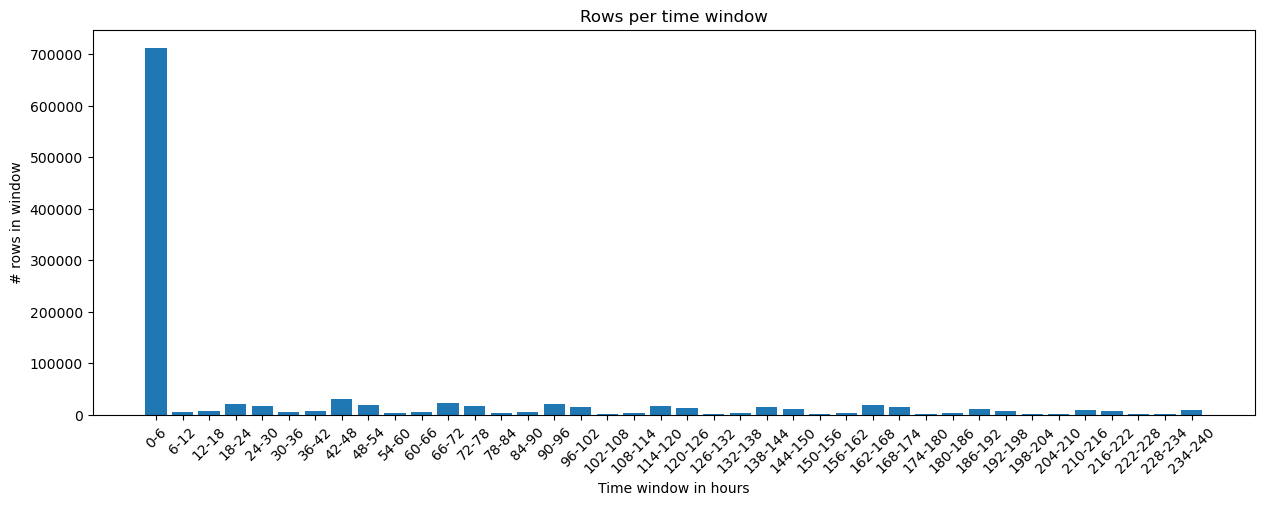

In [67]:
plt.figure(figsize=(15, 5))

plt.bar(new_column_names, rows_per_column)

plt.title('Rows per time window')

plt.xlabel('Time window in hours')
plt.xticks(rotation = 45)

plt.ylabel('# rows in window')

plt.show()

Not a great result in terms of the viability of the time window approach. The time window for 0-6 hours is much bigger than the other time windows becasue so much of the data consists of single blood tests for a patient. These all have a time value of 0.0, so they cluster in the first time window. 

Using the first time window to train and the test the model might yield better results than just using all the data with the engineered features, but direct comparisons between time windows would not be very meaningful because of the large size difference. 

I'll try the 0-6 time window in the pre-processing notebook just to see if it improves accuracy at all. It might be interesting if nothing else. 

In [79]:
# Subset and save the 0-6 time window data for further processing. 
leipzig_data_time_windows_0_to_6 = leipzig_data_time_windows[leipzig_data_time_windows['0-6 window']== 1]
leipzig_data_time_windows_0_to_6.to_csv('../data/processed/data_with_engineered_features/leipzig_full_data_with_engineered_features_0_to_6_window.csv', index=True)

## <a id='toc7_2_'></a>[Calculate windows for positive class using time to ICU admission](#toc0_)

Here I'll just subset the positive class based on time wondows from ICU admission. The negative class will stay the same, and be used as a pool for undersampling later on. 

In [85]:
def hours_from_ICU_subset(df,single_window = None, window_start= None, window_end=None):
    '''
    This function takes the data frame from one of the medical centers and removes any rows with a positive
    class that do not fit within the specified time window. The window is defined in hours.

    There are two ways to specify a window: 
    
    The single window parameter counts from ICU admission back to
    the value of the parameter. So for a window of 12 hours, all rows with a SecToIcu values that equals 12 hours or less
    will be included. 

    The window_start and window_end parameters are also defined in hours.
    If these are used, the function keeps only rows that fit between the start and end times. 
    So with a window_start of 6 and a window_end of 12, only rows with values between 6 and 12 hours would be included.

    Parameters:
    df = A pandas dataframe containing the necessary columns. 
    single_window = an int, indicating a number of hours
    window_start = an int, indicating a number of hours.
    window_end = an int, indicating a number of hours.

    '''

    #Separate out the positive class
    sepsis = df[df['Class'] == 1]
    control = df[df['Class'] == 0]

    if single_window != None:
        assert window_start == None, 'Window start is not None'
        assert window_end == None, 'Window end is not None'

        single_window_sec = single_window * 3600

        sepsis_filtered = sepsis[sepsis['SecToIcu']<= single_window_sec]

        concatenated_df = pd.concat([control, sepsis_filtered], axis=0, ignore_index=True)


    if single_window == None:
        assert window_start != None, 'single_window is None but there is no value for window_start'
        assert window_end != None, 'single_window is None but there is no value for window_start'

        window_start_sec = window_start_sec * 3600
        window_end_sec = window_end_sec * 3600

        sepsis_filtered = sepsis[sepsis[('SecToIcu' > window_start_sec)&('SecToIcu' <= window_end_sec)]]

        concatenated_df = pd.concat([control, sepsis_filtered], axis=0, ignore_index=True)


    return concatenated_df

In [106]:
#Generate various subsets to save for further modeling

#1 day
leipzig_6_hours_from_ICU = hours_from_ICU_subset(leipzig_data,single_window = 6, window_start= None, window_end = None)
leipzig_12_hours_from_ICU = hours_from_ICU_subset(leipzig_data,single_window = 12, window_start= None, window_end = None)
leipzig_18_hours_from_ICU = hours_from_ICU_subset(leipzig_data,single_window = 18, window_start= None, window_end = None)
leipzig_24_hours_from_ICU = hours_from_ICU_subset(leipzig_data,single_window = 24, window_start= None, window_end = None)

#2 days
leipzig_30_hours_from_ICU = hours_from_ICU_subset(leipzig_data,single_window = 30, window_start= None, window_end = None)
leipzig_36_hours_from_ICU = hours_from_ICU_subset(leipzig_data,single_window = 36, window_start= None, window_end = None)
leipzig_42_hours_from_ICU = hours_from_ICU_subset(leipzig_data,single_window = 42, window_start= None, window_end = None)
leipzig_48_hours_from_ICU = hours_from_ICU_subset(leipzig_data,single_window = 48, window_start= None, window_end = None)

# 3 days
leipzig_54_hours_from_ICU = hours_from_ICU_subset(leipzig_data,single_window = 54, window_start= None, window_end = None)
leipzig_60_hours_from_ICU = hours_from_ICU_subset(leipzig_data,single_window = 60, window_start= None, window_end = None)
leipzig_66_hours_from_ICU = hours_from_ICU_subset(leipzig_data,single_window = 66, window_start= None, window_end = None)
leipzig_72_hours_from_ICU = hours_from_ICU_subset(leipzig_data,single_window = 72, window_start= None, window_end = None)

#4 days
leipzig_78_hours_from_ICU = hours_from_ICU_subset(leipzig_data,single_window = 78, window_start= None, window_end = None)
leipzig_84_hours_from_ICU = hours_from_ICU_subset(leipzig_data,single_window = 84, window_start= None, window_end = None)
leipzig_90_hours_from_ICU = hours_from_ICU_subset(leipzig_data,single_window = 90, window_start= None, window_end = None)
leipzig_96_hours_from_ICU = hours_from_ICU_subset(leipzig_data,single_window = 96, window_start= None, window_end = None)

#5 days
leipzig_102_hours_from_ICU = hours_from_ICU_subset(leipzig_data,single_window = 102, window_start= None, window_end = None)
leipzig_108_hours_from_ICU = hours_from_ICU_subset(leipzig_data,single_window = 108, window_start= None, window_end = None)
leipzig_114_hours_from_ICU = hours_from_ICU_subset(leipzig_data,single_window = 114, window_start= None, window_end = None)
leipzig_120_hours_from_ICU = hours_from_ICU_subset(leipzig_data,single_window = 120, window_start= None, window_end = None)


# 1 week
leipzig_168_hours_from_ICU = hours_from_ICU_subset(leipzig_data,single_window = 168, window_start= None, window_end = None)

# 2 weeks
leipzig_336_hours_from_ICU = hours_from_ICU_subset(leipzig_data,single_window = 336, window_start= None, window_end = None)

# 3 weeks
leipzig_504_hours_from_ICU = hours_from_ICU_subset(leipzig_data,single_window = 504, window_start= None, window_end = None)

#4 weeks (31 days/ 1 month)
leipzig_744_hours_from_ICU = hours_from_ICU_subset(leipzig_data,single_window = 744, window_start= None, window_end = None)

# 5 weeks
leipzig_840_hours_from_ICU = hours_from_ICU_subset(leipzig_data,single_window = 840, window_start= None, window_end = None)

# 6 weeks
leipzig_1008_hours_from_ICU = hours_from_ICU_subset(leipzig_data,single_window = 1008, window_start= None, window_end = None)

# 7 weeks
leipzig_1176_hours_from_ICU = hours_from_ICU_subset(leipzig_data,single_window = 1176, window_start= None, window_end = None)

# 8 weeks
leipzig_1344_hours_from_ICU = hours_from_ICU_subset(leipzig_data,single_window = 1344, window_start= None, window_end = None)

# 12 weeks
leipzig_2016_hours_from_ICU = hours_from_ICU_subset(leipzig_data,single_window = 2016, window_start= None, window_end = None)


In [107]:
#Save subset dataframes
leipzig_6_hours_from_ICU.to_csv('../data/processed/data_with_engineered_features/data_subset_on_SecToIcu/leipzig_6_hrs_to_ICU.csv', index=True)
leipzig_12_hours_from_ICU.to_csv('../data/processed/data_with_engineered_features/data_subset_on_SecToIcu/leipzig_12_hrs_to_ICU.csv', index=True)
leipzig_18_hours_from_ICU.to_csv('../data/processed/data_with_engineered_features/data_subset_on_SecToIcu/leipzig_18_hrs_to_ICU.csv', index=True)
leipzig_24_hours_from_ICU.to_csv('../data/processed/data_with_engineered_features/data_subset_on_SecToIcu/leipzig_24_hrs_to_ICU.csv', index=True)
leipzig_30_hours_from_ICU.to_csv('../data/processed/data_with_engineered_features/data_subset_on_SecToIcu/leipzig_30_hrs_to_ICU.csv', index=True)
leipzig_36_hours_from_ICU.to_csv('../data/processed/data_with_engineered_features/data_subset_on_SecToIcu/leipzig_36_hrs_to_ICU.csv', index=True)
leipzig_42_hours_from_ICU.to_csv('../data/processed/data_with_engineered_features/data_subset_on_SecToIcu/leipzig_42_hrs_to_ICU.csv', index=True)
leipzig_48_hours_from_ICU.to_csv('../data/processed/data_with_engineered_features/data_subset_on_SecToIcu/leipzig_48_hrs_to_ICU.csv', index=True)
leipzig_54_hours_from_ICU.to_csv('../data/processed/data_with_engineered_features/data_subset_on_SecToIcu/leipzig_54_hrs_to_ICU.csv', index=True)
leipzig_60_hours_from_ICU.to_csv('../data/processed/data_with_engineered_features/data_subset_on_SecToIcu/leipzig_60_hrs_to_ICU.csv', index=True)
leipzig_66_hours_from_ICU.to_csv('../data/processed/data_with_engineered_features/data_subset_on_SecToIcu/leipzig_66_hrs_to_ICU.csv', index=True)
leipzig_72_hours_from_ICU.to_csv('../data/processed/data_with_engineered_features/data_subset_on_SecToIcu/leipzig_72_hrs_to_ICU.csv', index=True)
leipzig_78_hours_from_ICU.to_csv('../data/processed/data_with_engineered_features/data_subset_on_SecToIcu/leipzig_78_hrs_to_ICU.csv', index=True)
leipzig_84_hours_from_ICU.to_csv('../data/processed/data_with_engineered_features/data_subset_on_SecToIcu/leipzig_84_hrs_to_ICU.csv', index=True)
leipzig_90_hours_from_ICU.to_csv('../data/processed/data_with_engineered_features/data_subset_on_SecToIcu/leipzig_90_hrs_to_ICU.csv', index=True)
leipzig_96_hours_from_ICU.to_csv('../data/processed/data_with_engineered_features/data_subset_on_SecToIcu/leipzig_96_hrs_to_ICU.csv', index=True)
leipzig_102_hours_from_ICU.to_csv('../data/processed/data_with_engineered_features/data_subset_on_SecToIcu/leipzig_102_hrs_to_ICU.csv', index=True)
leipzig_108_hours_from_ICU.to_csv('../data/processed/data_with_engineered_features/data_subset_on_SecToIcu/leipzig_108_hrs_to_ICU.csv', index=True)
leipzig_114_hours_from_ICU.to_csv('../data/processed/data_with_engineered_features/data_subset_on_SecToIcu/leipzig_114_hrs_to_ICU.csv', index=True)
leipzig_120_hours_from_ICU.to_csv('../data/processed/data_with_engineered_features/data_subset_on_SecToIcu/leipzig_120_hrs_to_ICU.csv', index=True)

leipzig_168_hours_from_ICU.to_csv('../data/processed/data_with_engineered_features/data_subset_on_SecToIcu/leipzig_168_hrs_to_ICU.csv', index=True) 
leipzig_336_hours_from_ICU.to_csv('../data/processed/data_with_engineered_features/data_subset_on_SecToIcu/leipzig_336_hrs_to_ICU.csv', index=True) 
leipzig_504_hours_from_ICU.to_csv('../data/processed/data_with_engineered_features/data_subset_on_SecToIcu/leipzig_504_hrs_to_ICU.csv', index=True)
leipzig_744_hours_from_ICU.to_csv('../data/processed/data_with_engineered_features/data_subset_on_SecToIcu/leipzig_744_hrs_to_ICU.csv', index=True)

leipzig_840_hours_from_ICU.to_csv('../data/processed/data_with_engineered_features/data_subset_on_SecToIcu/leipzig_840_hrs_to_ICU.csv', index=True)
leipzig_1008_hours_from_ICU.to_csv('../data/processed/data_with_engineered_features/data_subset_on_SecToIcu/leipzig_1008_hrs_to_ICU.csv', index=True)
leipzig_1176_hours_from_ICU.to_csv('../data/processed/data_with_engineered_features/data_subset_on_SecToIcu/leipzig_1176_hrs_to_ICU.csv', index=True)
leipzig_1344_hours_from_ICU.to_csv('../data/processed/data_with_engineered_features/data_subset_on_SecToIcu/leipzig_1344_hrs_to_ICU.csv', index=True)
leipzig_2016_hours_from_ICU.to_csv('../data/processed/data_with_engineered_features/data_subset_on_SecToIcu/leipzig_2016_hrs_to_ICU.csv', index=True)

In [102]:
leipzig_data.columns

Index(['Id', 'Age', 'Sex', 'Diagnosis', 'Center', 'Time', 'SecToIcu', 'CRP',
       'HGB', 'MCV', 'PCT', 'PLT', 'RBC', 'WBC', 'HrsToIcu', 'Class',
       'test_sequence', 'interval_from_last_test', 'mean_time_between_tests',
       'median_time_between_tests', 'HGB_cumulative_mean',
       'HGB_cumulative_median', 'HGB_cumulative_std', 'HGB_ema_span_6',
       'HGB_ema_span_2', 'MCV_cumulative_mean', 'MCV_cumulative_median',
       'MCV_cumulative_std', 'MCV_ema_span_6', 'MCV_ema_span_2',
       'PLT_cumulative_mean', 'PLT_cumulative_median', 'PLT_cumulative_std',
       'PLT_ema_span_6', 'PLT_ema_span_2', 'RBC_cumulative_mean',
       'RBC_cumulative_median', 'RBC_cumulative_std', 'RBC_ema_span_6',
       'RBC_ema_span_2', 'WBC_cumulative_mean', 'WBC_cumulative_median',
       'WBC_cumulative_std', 'WBC_ema_span_6', 'WBC_ema_span_2'],
      dtype='object')